In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve,auc
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


# Build model

In [ ]:
%pip install Google-Colab-Transfer
import colab_transfer

gd = colab_transfer.get_path_to_home_of_google_drive()
lm = colab_transfer.get_path_to_home_of_local_machine()

colab_transfer.mount_google_drive()


Mounted at /content/drive/


In [ ]:
#!rm dataset/preprocessed_data_cropped/test/pneumonia -r
#!rm dataset/preprocessed_data_cropped/train/pneumonia -r


In [ ]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('drive/MyDrive/preprocessed_data_cropped.rar').extractall('dataset')

     |████████████████████████████████| 81kB 7.2MB/s 


In [ ]:
#set pytorch seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "dataset/preprocessed_data_cropped/"
model_name = "alexnet"# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 3# Number of classes in the dataset
#batch_size = 8# Batch size for training (change depending on how much memory you have)
num_epochs = 20# Number of epochs to train for 
# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

In [ ]:

def train_test_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    roc_auc_history=[]
    roc_auc_score_history=[]
    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            predictions=torch.cuda.FloatTensor([])
            y_true=torch.cuda.FloatTensor([])
            for batch_idx, sample in enumerate(dataloaders[phase]):
                inputs, labels = sample # or something similar
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                predictions=torch.cat((predictions,preds))
                y_true=torch.cat((y_true,labels.data))
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            y_true = preprocessing.label_binarize(y_true.cpu(), classes=[0, 1,2])
            y_pred=preprocessing.label_binarize(predictions.cpu(), classes=[0, 1,2])
            roc_auc=roc_auc_score(y_true, y_pred, average=None)
            macro_roc_auc_score=roc_auc_score(y_true, y_pred, average='macro')
            print("per class:{}, macro_roc_auc_score:{}".format(roc_auc,macro_roc_auc_score))

            # deep copy the model
            if phase == 'val' and macro_roc_auc_score > best_auc:
                best_auc = macro_roc_auc_score
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                roc_auc_history.append(roc_auc)
                roc_auc_score_history.append(macro_roc_auc_score)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val AUC: {:4f}'.format(best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history,roc_auc_history, roc_auc_score_history
#for ROC_AUC score
def activated_output_transform(output):
    y_pred, y = output
    y_pred = torch.sigmoid(y_pred)
    return y_pred, y

In [ ]:

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    if model_name == "alexnet":

        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size


# Load data

In [ ]:
path = data_dir
train_path=data_dir+"train"
test_path=data_dir+"test"

dataset=torchvision.datasets.ImageFolder(root=train_path,transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]))

testset=torchvision.datasets.ImageFolder(root=test_path,transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]))

print(dataset)
print(testset)

Dataset ImageFolder
    Number of datapoints: 13958
    Root location: dataset/preprocessed_data_cropped/train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 1579
    Root location: dataset/preprocessed_data_cropped/test
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:

#split into train and val sets
train, val=torch.utils.data.random_split(dataset, [11958,2000], generator=torch.Generator().manual_seed(0))
train.dataset = copy.copy(dataset)


t=np.ones(len(train))
for i in range(len(val)):
    if train[i][1]==0:
        t[i]=7966/517
    elif train[i][1]==2:
        t[i]=7966/5475
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(t, len(t),replacement=True)
print(train_sampler)


val.dataset.transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train.dataset.transform = transforms.Compose([ #only transforms for training set
        transforms.Resize((256,256)),        
        transforms.RandomHorizontalFlip(p=0.5),#random horizontal flip
        transforms.RandomAffine((-5,5), translate=(0.1,0.1), scale=None, shear=None, resample=0, fillcolor=0),#random translation[-5,5]
        transforms.RandomRotation((-5,5), resample=False, expand=False),#random rotation [-5,5]
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

training = torch.utils.data.DataLoader(train, batch_size=64,sampler=train_sampler)#add sampler if oversample
val = torch.utils.data.DataLoader(val, batch_size=64,shuffle=True)

dataloaders_dict={'train':training,'val':val}
testing=torch.utils.data.DataLoader(testset, batch_size=1,shuffle=True)


covid83,normal1157,pneumonia760


# Optimizer, choose which weights to update

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Send the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = []
last_layer=[]
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
              params_to_update.append(param)
              print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True and name!='classifier.6.weight' and name!='classifier.6.bias':
            params_to_update.append(param)
            print("\t",name)
        else:
            last_layer.append(param)
            print('last layer:', name)
# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD([{'params':params_to_update}, {'params': last_layer, 'lr': 0.0002}], lr=0.0001, momentum=0.9)
optimizer_ft = optim.SGD([{'params':params_to_update}, {'params': last_layer, 'lr': 0.0002}], lr=0.0001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.weight
	 features.3.bias
	 features.6.weight
	 features.6.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
last layer: classifier.6.weight
last layer: classifier.6.bias


In [ ]:
print(optimizer_ft)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    lr: 0.0002
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


# Training and validate

In [ ]:

# Setup the loss fxn
#assign weights to each label, for imbalanced task
#covid: 617
#normal: 8851
#pneumonia: 6069

weights = [1,1,1] #maybe change weights, covid seems to be overfitting
class_weights = torch.cuda.FloatTensor(weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)#add class imbalance arg
model_ft, hist, roc_auc_hist, roc_auc_score_history = train_test_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)
#{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}

Epoch 0/19
----------
train Loss: 0.6695 Acc: 0.7187
per class:[0.77752208 0.8194203  0.76810662], macro_roc_auc_score:0.7883496682157807
val Loss: 0.3213 Acc: 0.8820
per class:[0.80209017 0.88649565 0.87188956], macro_roc_auc_score:0.8534917933567305

Epoch 1/19
----------
train Loss: 0.5004 Acc: 0.8043
per class:[0.8472728  0.88400929 0.82826584], macro_roc_auc_score:0.8531826451336966
val Loss: 0.2957 Acc: 0.8950
per class:[0.83811028 0.90522965 0.89159718], macro_roc_auc_score:0.8783123659921909

Epoch 2/19
----------
train Loss: 0.4687 Acc: 0.8179
per class:[0.86237756 0.89063207 0.83676284], macro_roc_auc_score:0.8632574910334098
val Loss: 0.2815 Acc: 0.9005
per class:[0.83888627 0.90987486 0.89721335], macro_roc_auc_score:0.881991495662084

Epoch 3/19
----------
train Loss: 0.4181 Acc: 0.8402
per class:[0.88901712 0.89660439 0.8544975 ], macro_roc_auc_score:0.8800396717457462
val Loss: 0.2773 Acc: 0.8995
per class:[0.87464771 0.90752453 0.89349872], macro_roc_auc_score:0.8918903

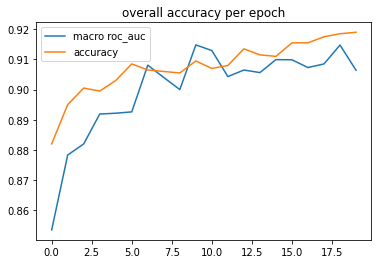

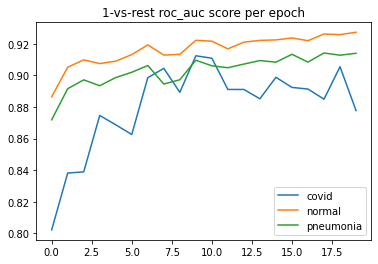

In [ ]:
#plot history
roc_auc_hist=np.array(roc_auc_hist)
plt.title('overall accuracy per epoch')
plt.plot(roc_auc_score_history,label='macro roc_auc')
plt.plot(hist,label='accuracy')
plt.legend()
plt.show()

plt.title('1-vs-rest roc_auc score per epoch')
plt.plot(roc_auc_hist[:,0],label='covid')
plt.plot(roc_auc_hist[:,1],label='normal')
plt.plot(roc_auc_hist[:,2],label='pneumonia')

plt.legend()
plt.show()

In [ ]:
running_loss = 0.0
running_corrects = 0
predictions=torch.tensor([])
y_true=torch.tensor([])
for batch_idx, sample in enumerate(testing):
    inputs, labels = sample # or something similar
    inputs = inputs.to(device)
    labels = labels.to(device)


    # forward

    outputs = model_ft(inputs)

    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    predictions=torch.cat((predictions.cpu(),preds.cpu()))
    y_true=torch.cat((y_true.cpu(),labels.data.cpu()))
epoch_loss = running_loss / len(testing.dataset)
epoch_acc = running_corrects.double() / len(testing.dataset)
print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
print (confusion_matrix(y_true, predictions))
y = preprocessing.label_binarize(y_true, classes=[0, 1,2])
y_pred=preprocessing.label_binarize(predictions, classes=[0, 1,2])
roc_auc=roc_auc_score(y, y_pred, average=None)
macro_roc_auc_score=roc_auc_score(y, y_pred, average='macro')
print("per class:{}, macro_roc_auc_score:{}".format(roc_auc,macro_roc_auc_score))


Loss: 0.2858 Acc: 0.9044
[[ 71   6  23]
 [  6 805  74]
 [  8  34 552]]
per class:[0.85026707 0.92598382 0.91540789], macro_roc_auc_score:0.8972195914651375
